# Chess Analysis : Lichess.org

Ce dataset est récupéré depuis kaggle : https://www.kaggle.com/datasets/datasnaek/chess?resource=download

Il correspond à des parties d'échecs récupérés en ligne sur le site : https://lichess.org/ via l'API mis en place : https://lichess.org/api

Les informations à propos de ce dataset sont les suivantes : 

"General Info

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. I will also upload more games in the future as I collect them. This set contains the:

- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)"


Mon objectif sur ce jeu de données est dans un premier temps de faire une analyse des différentes informations que l'on peut récupérer, étant moi même un joueur d'échec occassionnel mais très passionné.
Pour cela, je vais utiliser les différentes connaissances que j'ai sur les librairies Python suivantes :

- Numpy
- Pandas
- Matplotlib

Il sera tout à fait possible de mettre en place une prédiction par la suite en fonction de ce qu'on aura pu analyser.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/chess.csv',sep=',')

In [46]:
# On affiche les premières lignes de données avec la fonction head(). Par défaut, 5 lignes sont affichées.
data.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,date_debut,date_fin,echelle_rank_blanc,echelle_rank_noir,clean_opening
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,2017-08-31,2017-08-31,1500-1700,1100-1300,Slav Defense
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,2017-08-30,2017-08-30,1300-1500,1100-1300,Nimzowitsch Defense


In [4]:
# On peut également affiché le nom des différentes colonnes de notre dataset
data.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

### Premières observations (les dates)

Nous pouvons observer la présence de date ("created_at", "last_move_at") indiquant probablement le début et la fin de la partie d'échec.
Les valeurs sont des nombres au format "float64", et le fait de voir "e+12" indique très certainement une date en "ms".
Pour information, "e+12" est équivalent à dire : 10^12 ce qui correspond bien à du milliseconde (10^15 serait du nanoseconde).

--> Pour le moment, je garde toutes les informations du jeu de données, mais je vais créer deux nouvelles colonnes <b>"date_début"</b> et <b>"date_fin"</b> en transformant ces dates en vrai format de date pour un traitement plus simple. On pourra également réindéxer notre jeu de donnée par rapport à la date début par exemple afin de faire des analyses temporelles.

Une analyse temporelle pourrait par exemple nous permettre de voir si le nombre de partie augmente au cours de l'année (vacances d'été, d'hiver...). Je pourrais seulement m'attacher à des périodes de vacances "communes" entre les différents pays car nous avons pas d'informations sur l'origine des joueurs de ce jeu de données.
Je pourrais également voir dans le temps les "ouvertures" utilisées dans les parties par rapport au grand tournois d'échec, ce qui permettrait de voir si les joueurs amateurs en ligne sont inspirés par les joueurs professionnels (une ouverture étant les premiers coups utilisés dans une partie, qui est renseigné dans la colonne "opening_name")

In [5]:
data['date_debut'] = pd.to_datetime(data['created_at'],unit='ms').dt.date

In [6]:
data['date_fin'] = pd.to_datetime(data['last_move_at'],unit='ms').dt.date

On va également effectuer une analyse stastique très simple grâce à la méthode "describe" de pandas afin d'obtenir des informations de moyennes, min, max... sur notre jeu de données.

-> Voici les observations très rapide que l'on peut faire grâce à ces informations :

- En moyenne, les parties sont jouées en 60.47 coups. La partie la plus courte faisant 1 coup (sûrement un joueur qui ne s'est pas connecté à la partie ou qui a "annulé" le match. Nous pourrons regarder plus en détail cette information.) La partie la plus longue fait 349 coups.

- Le classement moyen des joueurs avec les pièces blanches est de 1596.63 elo avec un minimum de 784 elo et un maximum de 2700 elo. L'écart-type est de 291.25 elo.

- Le classement moyen des joueurs avec les pièces noires est de 1588.83 elo avec un minimum de 789 elo et un maximum de 2723 elo. L'écart-type est de 291.04 elo.

1) Pour rappel, l'écart-type sert à mesurer la dispersion/l'étalement des valeurs autour de leur moyenne. Plus l'écart-type est faible, plus la population est "homogène".

2) Pour information, le système pour calculer ce nombre "élo" provient du classement <b>"Glicko"</b> et <b>"Glicko-2"</b> voici ce qu'on peut lire sur le sujet sur Wikipédia : 

"Le classement Glicko a été inventé par le professeur <b>Mark Glickman</b> dans le but d'améliorer le système de classement Elo, et d'abord comme système d'évaluation de la force aux échecs. Sa caractéristique principale est de tenir compte de la fiabilité du classement avec un <b>paramètre RD</b> (pour rating deviation, écart type du classement).

Les deux systèmes Glicko et Glicko-2 appartiennent au domaine public et sont utilisés par des serveurs de jeu en ligne comme FICS et Lichess. Les formules employées se trouvent sur le site officiel.

Le paramètre RD est une mesure de la <b>fiabilité du classement</b>. Par exemple, un joueur avec un classement de 1500 et un RD de 50 aura une force réelle comprise entre 1400 et 1600 avec une probabilité de 95 %. La variation de classement après une partie dépendra aussi des RD respectifs : si son propre RD est faible et celui de l'adversaire est élevé, le changement sera moindre, car le classement de l'adversaire n'est pas connu avec beaucoup de précision et ne reflète peut-être pas correctement sa force réelle.

Le paramètre RD décroit après chaque partie jouée, et augmente après une période d'inactivité."


In [7]:
data.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


### Autres observations

Il peut être intéressant de regarder la répartition des joueurs en fonction du niveau (rating) pour voir dans quelle tranche se trouve le plus grand nombre de joueur dans ce dataset.

Pour ce faire, nous allons tout d'abord réduire le nombre de valeur à afficher afin de simplifier l'affichage, en réduisant les classements ayant une occurrence supérieur à 40 fois.

Nous observons rapidement que <b>l'élo "1500"</b> est très représenté par rapport au reste des classements (plus de 800 fois !!)
-> Cette affichage rend la lecture compliqué du fait de cette écart énorme, ce qui ne rend pas simple la lecture sur l'échelle graphique.

Nous allons donc filtrer cette valeur en supprimant les occurences supérieurs à 300 afin de voir une meilleure visibilité des autres classements.
-> Nous observons que la tranche de classement <b>1475 - 1625</b> est très représenté. Ce qui n'est pas étonnant lorsque l'on connaît un peu le monde des échecs, puisque <b>le classement de 1500 élo est souvent donné "par défaut"</b> sur les différents sites de jeux d'échecs en ligne (lichess.org, chess.com...)

In [8]:
classement, occurences = np.unique(data['white_rating'],return_counts=True)

<BarContainer object of 12 artists>

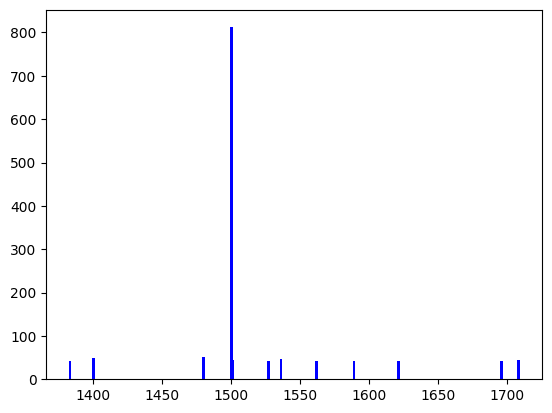

In [9]:
plt.bar(x=classement[occurences > 40],height=occurences[occurences > 40],color='blue', width=2)

In [10]:
occurences[classement == 1500]

array([812], dtype=int64)

<BarContainer object of 11 artists>

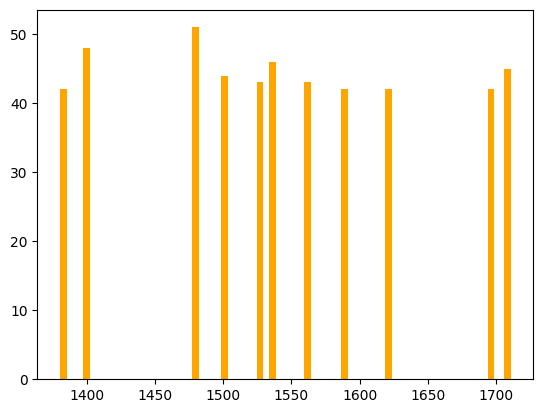

In [11]:
plt.bar(x=classement[(occurences > 40) & (occurences<300)],height=occurences[(occurences > 40) & (occurences<300)],color='orange', width=5)

A présent, il est possible de se demander qu'il serait plus pertinent de regrouper ces classements par "tranche" ce qui faciliterait l'analyse.
Pour cela, nous devons déjà savoir quels sont les minimum et maximum de nos classement avec pièces blanches et pièces noires.

Puis, après avoir obtenu ces chiffres, nous allons "construire" des intervalles de classements avec des écarts de 200 points de élo afin de se donner une idée de la répartition des joueurs sur les différents classements.

Bien entendu, nous devrions obtenir plus ou moins le même chiffre avec les pièces blanches et noires (puisqu'une partie se joue toujours entre un joueur avec les pièces blanches, et un autre avec les pièces noires), mais il pourra <b>effectivement avoir un delta</b>. Ce delta va provenir de ces intervalles de classements, puisqu'un <b>joueur à 1500 élo de classement (1 intervalle), peut se retrouver à jouer contre un adversaire à 1465 (1 autre intervalle)...</b> ce qui explique la différence que l'on pourra observer. Ce delta peut provenir de la <b>formule</b> qui est utilisé pour le calcul du classement, mais également <b>du système de "match making"</b> du site en question, puisqu'un joueur avec une grande série de victoire à 1600 élo par exemple, peut être amené à être "matché" pour jouer avec des joueurs de 1700+ élo afin de le "challenger" et de lui permettre de monter plus rapidement, et ainsi jouer avec des joueurs de son "vrai" niveau. Evidemment, ce delta va drastiquement se réduire au fur et à mesure, lorsque le joueur commence à avoir de nombreuses parties à son actif.

In [12]:
data['white_rating'].min()

784

In [13]:
data['white_rating'].max()

2700

In [14]:
data['black_rating'].min()

789

In [15]:
data['black_rating'].max()

2723

Nous créons donc nos intervalles désirés, ainsi que les conditions afin de peupler nos différents intervalles.

In [16]:
conditions = [
    (data['white_rating'] >= 700) & (data['white_rating'] < 900),
    (data['white_rating'] >= 900) & (data['white_rating'] < 1100),
    (data['white_rating'] >= 1100) & (data['white_rating'] < 1300),
    (data['white_rating'] >= 1300) & (data['white_rating'] < 1500),
    (data['white_rating'] >= 1500) & (data['white_rating'] < 1700),
    (data['white_rating'] >= 1700) & (data['white_rating'] < 1900),
    (data['white_rating'] >= 1900)
]

intervalles = ['700-900','900-1100','1100-1300','1300-1500','1500-1700','1700-1900','1900-2000+']

data['echelle_rank_blanc'] = np.select(conditions,intervalles)

conditions = [
    (data['black_rating'] >= 700) & (data['black_rating'] < 900),
    (data['black_rating'] >= 900) & (data['black_rating'] < 1100),
    (data['black_rating'] >= 1100) & (data['black_rating'] < 1300),
    (data['black_rating'] >= 1300) & (data['black_rating'] < 1500),
    (data['black_rating'] >= 1500) & (data['black_rating'] < 1700),
    (data['black_rating'] >= 1700) & (data['black_rating'] < 1900),
    (data['black_rating'] >= 1900)
]

data['echelle_rank_noir'] = np.select(conditions,intervalles)

In [17]:
classement_blanc, occurences_blanc = np.unique(data['echelle_rank_blanc'],return_counts=True)
classement_noir, occurences_noir = np.unique(data['echelle_rank_noir'],return_counts=True)

In [18]:
my_order = [5,6,0,1,2,3,4]
classement_blanc = [classement_blanc[i] for i in my_order]
occurences_blanc = [occurences_blanc[i] for i in my_order]

classement_noir = [classement_noir[i] for i in my_order]
occurences_noir = [occurences_noir[i] for i in my_order]

Après avoir manipulé nos données, créé nos intervalles, nous observons qu'il y a bien un grand nombre de joueur sur la plage "1300-1900" avec le plus haut pic atteint sur l'intervalle "1500-1700"

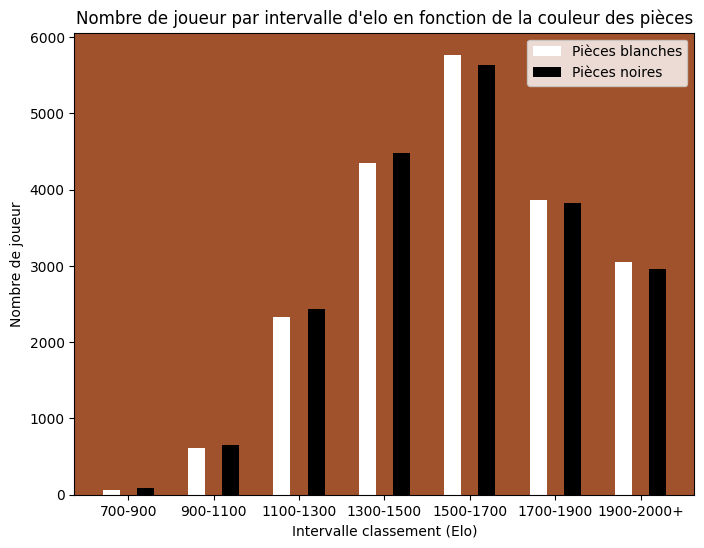

In [19]:
plt.figure(figsize=(8,6))
X_axis = np.arange(len(classement_blanc))
ax = plt.axes()
ax.set_facecolor('sienna')
plt.bar(x=X_axis-0.2,height=occurences_blanc,color='white', width=0.2, label="Pièces blanches")
plt.bar(x=X_axis+0.2,height=occurences_noir,color='black', width=0.2, label="Pièces noires")
plt.xticks(X_axis, classement_blanc)
plt.xlabel("Intervalle classement (Elo)")
plt.ylabel("Nombre de joueur")
plt.title("Nombre de joueur par intervalle d'elo en fonction de la couleur des pièces")
plt.legend()

In [20]:
ouverture, occurence = np.unique(data['opening_name'],return_counts=True)

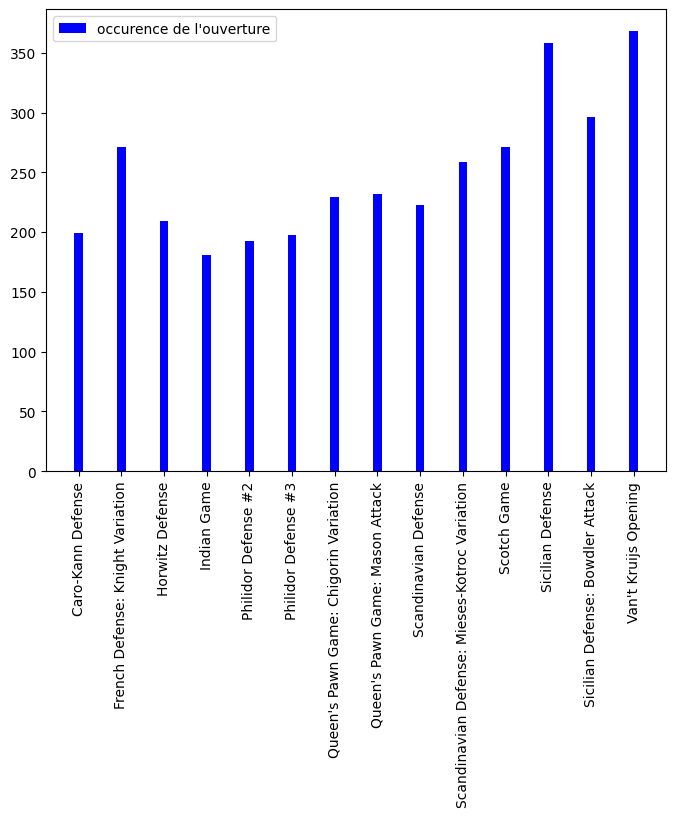

In [21]:
plt.figure(figsize=(8,6))
plt.bar(x=ouverture[occurence > 180],height=occurence[occurence>180],color='blue', width=0.2, label="occurence de l'ouverture")
plt.xticks(rotation=90)
plt.legend()

### Nettoyage des ouvertures (colonne "opening_name")

On observe que les ouvertures sont très détaillées. Nous pouvons remédier à ce problème en faisant un nettoyage de ces données.
De manière générale, il faut savoir que les ouvertures sont données par le premier coup jouer par les pièces blanches, et le premier coup des pièces noires va jouer un rôle sur "la variante".
Par exemple, dans le graphique ci-dessus, on observe plusieurs fois l'ouverture <b>Queen's Pawn Game </b> ce qui indique que le joueur avec les pièces blanches a commencé la partie par 1. d4, qui est un coup très répandu dans les échecs. L'information qu'il y a après les ":" est la variante choisie par le joueur avec les pièces noires, par exemple : <b> Chigorin Variation </b>
(cf : https://en.wikipedia.org/wiki/Chigorin_Defense)
    
Après ce nettoyage, nous pouvons réafficher le même graphique de ci-dessus pour voir si il y a du changement dans les occurences :

In [22]:
data['clean_opening'] = data['opening_name'].str.replace('\:\s.*|\s\|.*|\s\#[0-9]','',regex=True)

In [23]:
ouverture, occurence = np.unique(data['clean_opening'],return_counts=True)

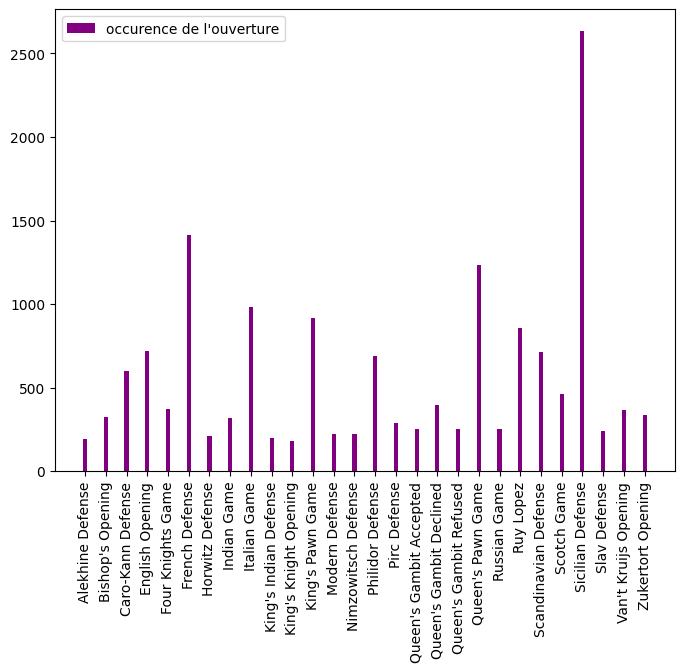

In [24]:
plt.figure(figsize=(8,6))
plt.bar(x=ouverture[occurence > 180],height=occurence[occurence>180],color='purple', width=0.2, label="occurence de l'ouverture")
plt.xticks(rotation=90)
plt.legend()

Il peut être intéressant d'observer le "type de victoire". Les victoires possibles aux échecs sont : 

- par "échec et mat" (mate), ce qui signifie que le roi adverse a été "capturé"
- par "abandon" (resign), ce qui signifie que le joueur a abandonné
- par "égalité" (draw), ce qui peut arriver lors de la répétition de 3 fois le même coup par exemple signifiant qu'aucun des deux joueurs ne pensent pouvoir "gagner du terrain" sur le jeu adverse
- par "manque de temps" (out of time), signifiant que les parties se sont jouées avec un temps à la pendule et que l'un des deux joueurs n'avaient plus de temps pour jouer

Rien de très pertinent dans ce résultat. Cependant, nous pouvons observer que le joueur blanc est celui qui abandonne le plus souvent, étant donné qu'il est le "premier" à jouer, on peut imaginer qu'il sera le premier à "manquer de coup". Cependant cette approche n'est pas forcément vrai car dans une partie, il y a de nombreuse façon de "gagner un temps" sur le joueur adverse en lui refaisant bouger une pièce déjà jouée ce qui n'est pas forcément recommandé car n'améliore pas sa propre position.

Les couleurs : 

- bleu clair : pièce blanche
- noir : pièces noires
- gris clair : match nul

<AxesSubplot: xlabel='victory_status,winner'>

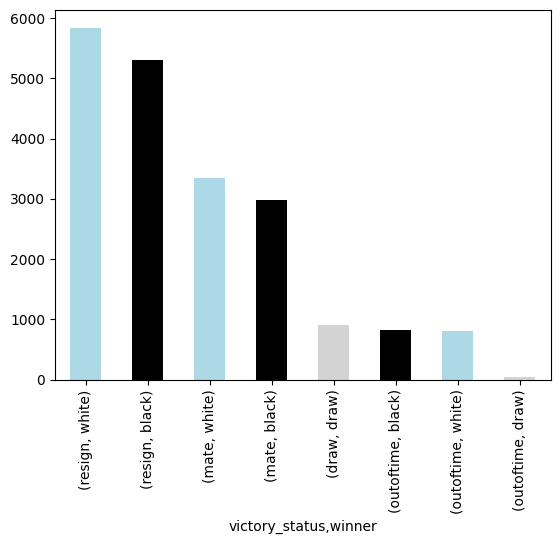

In [45]:
data[['victory_status','winner']].value_counts().plot.bar(color=['lightblue','black','lightblue','black','lightgrey','black','lightblue','lightgrey'])